In [1]:
cd rp_ai_Triamese_ViT_v2

/home/jupyter-nafisha/Brain_age/rp_ai_Triamese_ViT_v2


In [2]:
import numpy as np
import torch.nn as nn
import os,shutil,torch
import matplotlib.pyplot as plt
# from utils.config import opt
from load_data import IMG_Folder
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_absolute_error
from load_data import  IMG_Folder
from model.MultiViewViT import MultiViewViT
import torch.nn.functional as F
import cv2
from load_data import nii_loader
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
import nibabel as nib

def nii_loader(path, dtype=np.float32, mmap_mode='r'):
    """
    Load NIfTI file with memory mapping option for large files.

    Args:
        path: Path to NIfTI file
        dtype: Data type to cast to (default: float32)
        mmap_mode: Memory mapping mode (default: 'r' for read-only)
                   Set to None to load data into memory
    """
    img = nib.load(str(path))
    # Use memory mapping for large files
    data = img.get_fdata(dtype=dtype, caching='unchanged')
    return data

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MultiViewViT(
    image_sizes=[(91, 109), (91, 91), (109, 91)],
    patch_sizes=[(7, 7), (7, 7), (7, 7)],
    num_channals=[91,109,91],
    vit_args={'emb_dim': 768, 'mlp_dim': 3072, 'num_heads': 12, 'num_layers': 12, 'num_classes': 1,
              'dropout_rate': 0.1, 'attn_dropout_rate': 0.0},
    mlp_dims=[3,128,256,512,1024,512,256,128,1]
)

In [5]:
model = nn.DataParallel(model).to(device)
criterion = nn.MSELoss().to(device)
model.load_state_dict(torch.load('/home/jupyter-nafisha/Brain_age/output_dirMulti_VIT__original_best_model.pth.tar')['state_dict'])

<All keys matched successfully>

In [6]:
import pandas as pd
df= pd.read_excel('/home/jupyter-nafisha/Brain_age/CSVs/OASIS_Vit-normal.xlsx')

df["predicted_age"] = np.nan

In [7]:
len(os.listdir('/home/jupyter-nafisha/Brain_age/OASIS1_preprocessed'))

27

In [8]:
def white0(image, threshold=0):
    image = image.astype(np.float32)
    mask = (image > threshold).astype(int)

    # Vectorized implementation to avoid unnecessary memory allocation
    image_h = image * mask

    # Calculate mean and std only for relevant voxels
    non_zero_voxels = np.sum(mask)
    if non_zero_voxels > 0:
        mean = np.sum(image_h) / non_zero_voxels

        # More memory efficient way to calculate std
        std_sum = np.sum((image_h - mean * mask) ** 2)
        std = np.sqrt(std_sum / non_zero_voxels)

        if std > 0:
            normalized = mask * (image - mean) / std
            # Use in-place operations to reduce memory usage
            image = normalized + image * (1 - mask)
            return image

    # Default case
    return np.zeros_like(image, dtype=np.float32)

In [10]:
device = next(model.parameters()).device

for idx, row in df.iterrows():
    path = os.path.join('/home/jupyter-nafisha/Brain_age/OASIS1_preprocessed',
                        row['FILE_NAME'])
    if not os.path.exists(path):
        print("Missing file:", path)
        continue
    # Load NIfTI
    img = nii_loader(path)
    # Apply same preprocessing as Dataset
    img = white0(img)
    img = np.ascontiguousarray(img, dtype=np.float32)
    img = torch.from_numpy(img).type(torch.FloatTensor).unsqueeze(0)
    img = img.to(device)
    with torch.no_grad():
        pred, (attn1, attn2, attn3) = model(img, return_attention_weights=True)

    age = pred.item()
    df.at[idx, "predicted_age"] = age
    print(row['AGE'], age)


74 12.294957160949707
55 12.76527214050293
28 12.422683715820312
18 12.734807014465332
24 13.20235824584961
21 13.871631622314453
20 13.274479866027832
74 12.547080993652344
52 12.883707046508789
30 13.420031547546387
81 12.945088386535645
19 13.21137523651123
21 13.588744163513184
39 13.688619613647461
89 13.501340866088867
48 12.152341842651367
24 13.273487091064453
58 12.79124927520752
43 12.543027877807617
21 12.676111221313477
65 11.701047897338867
89 13.0736083984375
80 11.913734436035156
51 13.740097045898438
27 12.965128898620605
23 12.780328750610352
38 13.10500717163086


In [11]:
df

,FILE_NAME,AGE,SEX,predicted_age
0,OAS1_0001_MR1_mpr-3_anon.nii.gz,74,0,12.294957
1,OAS1_0002_MR1_mpr-1_anon.nii.gz,55,0,12.765272
2,OAS1_0004_MR1_mpr-3_anon.nii.gz,28,1,12.422684
3,OAS1_0005_MR1_mpr-1_anon.nii.gz,18,1,12.734807
4,OAS1_0006_MR1_mpr-3_anon.nii.gz,24,0,13.202358
5,OAS1_0007_MR1_mpr-1_anon.nii.gz,21,1,13.871632
6,OAS1_0009_MR1_mpr-3_anon.nii.gz,20,0,13.274480
7,OAS1_0010_MR1_mpr-3_anon.nii.gz,74,1,12.547081
8,OAS1_0011_MR1_mpr-2_anon.nii.gz,52,0,12.883707
9,OAS1_0012_MR1_mpr-3_anon.nii.gz,30,1,13.420032


In [12]:
import numpy as np

mae = np.mean(np.abs(df['AGE'] - df['predicted_age']))
print("MAE =", mae)

MAE = 31.960468610127766


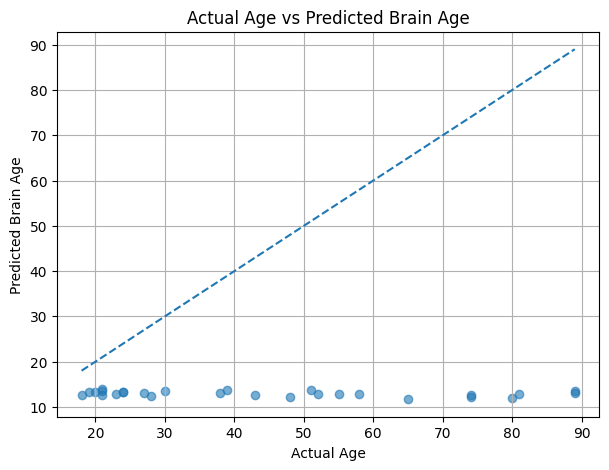

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(df['AGE'], df['predicted_age'], alpha=0.6)

# Add diagonal y=x line
x = np.linspace(df['AGE'].min(), df['AGE'].max(), 100)
plt.plot(x, x, linestyle='--')

plt.xlabel('Actual Age')
plt.ylabel('Predicted Brain Age')
plt.title('Actual Age vs Predicted Brain Age')
plt.grid(True)
plt.show()

In [14]:
# file= '/home/jupyter-nafisha/Brain_age/OAS1_0001_MR1_mpr-3_anon.nii.gz'
# img = nii_loader(file)
# img = np.ascontiguousarray(img, dtype=np.float32)
# img = torch.from_numpy(img).type(torch.FloatTensor)
# img_tensor= img.unsqueeze(0)
# img_tensor.shape

# prediction.py

In [15]:
excel_path= '/home/jupyter-nafisha/Brain_age/CSVs/OASIS_Vit-normal.xlsx'
test_folder = '/home/jupyter-nafisha/Brain_age/OASIS1_preprocessed'
test_data = IMG_Folder(excel_path, test_folder)

In [16]:
os.path.exists(os.path.join(test_folder,'OAS1_0040_MR1_mpr-2_anon.nii.gz'))

True

In [17]:
img, sid, slabel, smale = test_data[2]
img.shape, sid, slabel, smale

(torch.Size([91, 109, 91]), 'OAS1_0004_MR1_mpr-3_anon.nii.gz', 28, 1)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MultiViewViT(
    image_sizes=[(91, 109), (91, 91), (109, 91)],
    patch_sizes=[(7, 7), (7, 7), (7, 7)],
    num_channals=[91,109,91],
    vit_args={'emb_dim': 768, 'mlp_dim': 3072, 'num_heads': 12, 'num_layers': 12, 'num_classes': 1,
              'dropout_rate': 0.1, 'attn_dropout_rate': 0.0},
    mlp_dims=[3,128,256,512,1024,512,256,128,1]
)

In [22]:
model = nn.DataParallel(model).to(device)
criterion = nn.MSELoss().to(device)
model.load_state_dict(torch.load('/home/jupyter-nafisha/Brain_age/output_dirMulti_VIT__original_best_model.pth')['state_dict'])

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter-nafisha/Brain_age/output_dirMulti_VIT__original_best_model.pth'

In [23]:
test_loader = torch.utils.data.DataLoader(test_data
                                         ,batch_size= 1
                                         ,num_workers=4
                                         ,pin_memory=True
                                         ,drop_last=True
                                         )

In [24]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
# rm -rf /home/jupyter-nafisha/Brain_age/OASIS1_preprocessed/.ipynb_checkpoints

In [26]:
losses = AverageMeter()
MAE = AverageMeter()

In [27]:
model.eval() # switch to evaluate mode
out, targ, ID, Attn1, Attn2, Attn3 = [], [], [], [], [], []
target_numpy, predicted_numpy, ID_numpy = [], [], []

In [28]:
def metric(output, target):
    target = target.data.numpy()
    pred = output.cpu()
    pred = pred.data.numpy()
    return mae


TEST  : [steps 27], Loss 2668.1826,  MAE:  31.9605, R²: -3.8386 

STD_err =  23.758022
 CC:     [[ 1.         -0.28912968]
 [-0.28912968  1.        ]]
PAD spear man cc SignificanceResult(statistic=np.float64(-0.9952641291961366), pvalue=np.float64(7.816991001854953e-27))
spear man cc SignificanceResult(statistic=np.float64(-0.2013752106663353), pvalue=np.float64(0.313824289140536))
mean pad: -45.866535



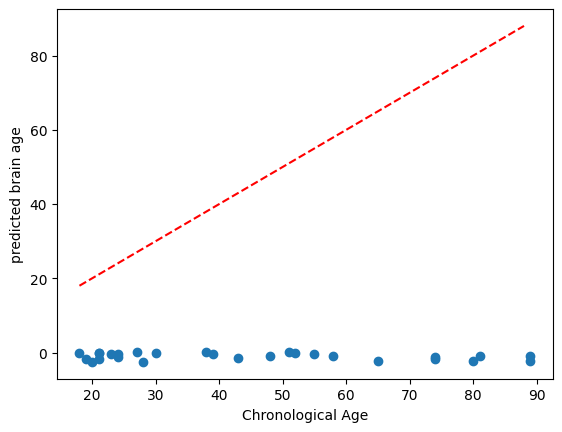

In [29]:
with torch.no_grad():

    for _, (input, ids ,target,male) in enumerate(test_loader):
        input = input.to(device).type(torch.FloatTensor)

        # print('input shape:- ',input.shape)
        # print(ids)
        
        # ======= convert male lable to one hot type ======= #
        male = torch.unsqueeze(male,1)
        male = torch.zeros(male.shape[0],2).scatter_(1,male,1)
        male = male.type(torch.FloatTensor).to(device)

        # print(male)

        target = torch.from_numpy(np.expand_dims(target,axis=1))
        target = target.type(torch.FloatTensor).to(device)

        # print(target)

        output, (attn1, attn2, attn3) = model(input, return_attention_weights=True)
        # print(output)
        out.append(output.cpu().numpy())
        targ.append(target.cpu().numpy())
        ID.append(ids)
        # print(ID)

        loss = criterion(output, target)
        mae = metric(output.detach(), target.detach().cpu())

        # ======= measure accuracy and record loss ======= #
        losses.update(loss, input.size(0))
        MAE.update(mae, input.size(0))
        # break

    targ = np.asarray(targ)
    out = np.asarray(out)
    ID = np.asarray(ID)

    # print("targ",targ)
    # print("ID", ID)

    for idx in targ:
        for i in idx:
            target_numpy.append(i)

    for idx in out:
        for i in idx:
            predicted_numpy.append(i)
    
    for idx in ID:
        for i in idx:
            ID_numpy.append(i)

    target_numpy = np.asarray(target_numpy)
    predicted_numpy = np.asarray(predicted_numpy)
    ID_numpy = np.asarray(ID_numpy)

    errors = predicted_numpy - target_numpy
    abs_errors = np.abs(errors)
    errors = np.squeeze(errors,axis=1)
    abs_errors = np.squeeze(abs_errors,axis=1)
    target_numpy = np.squeeze(target_numpy,axis=1)
    predicted_numpy = np.squeeze(predicted_numpy,axis=1)

    original_data = nii_loader('/home/jupyter-nafisha/Brain_age/Leuven_50683.nii.gz')
    original_data = original_data[45, :, :]

    r2 = r2_score(target_numpy, predicted_numpy)



    # ======= output several results  ======= #
    print('===============================================================\n')
    print(
        'TEST  : [steps {0}], Loss {loss.avg:.4f},  MAE:  {MAE.avg:.4f}, R²: {r2:.4f} \n'.format(
        len(test_loader), loss=losses, MAE=MAE, r2=r2))

    print('STD_err = ', np.std(errors))  
    print(' CC:    ',np.corrcoef(target_numpy,predicted_numpy))
    print('PAD spear man cc',spearmanr(errors,target_numpy,axis=1))
    print('spear man cc',spearmanr(predicted_numpy,target_numpy,axis=1))
    print('mean pad:',np.mean(errors))

    print('\n =================================================================')

    # if save_npy:
    savepath = '/home/jupyter-nafisha/Brain_age/test.npz'
    np.savez(savepath 
            ,target=target_numpy
            ,prediction=predicted_numpy
            ,ID=ID_numpy)

    # ======= Draw scatter plot of predicted age against true age ======= #
    # if figure is True:
    plt.figure()
    lx = np.arange(np.min(target_numpy),np.max(target_numpy))
    plt.plot(lx,lx,color='red',linestyle='--')
    plt.scatter(target_numpy,predicted_numpy)
    plt.xlabel('Chronological Age')
    plt.ylabel('predicted brain age')
    plt.savefig('/home/jupyter-nafisha/Brain_age/pre_vs_act.png')
    plt.show()

    # return MAE,np.corrcoef(target_numpy,predicted_numpy)

In [30]:
MAE.avg

np.float64(31.960468610127776)

In [31]:
pwd

'/home/jupyter-nafisha/Brain_age/rp_ai_Triamese_ViT_v2'

In [32]:
import numpy as np
import pandas as pd

# Path to your npz file
npz_path =  '/home/jupyter-nafisha/Brain_age/test.npz'

# Load the .npz file
data = np.load(npz_path)

dfs = {}
for key in data.files:
    arr = data[key]
    if arr.ndim == 1:
        dfs[key] = pd.Series(arr)
    elif arr.ndim == 2:
        df = pd.DataFrame(arr, columns=[f"{key}_{i}" for i in range(arr.shape[1])])
        dfs[key] = df
    else:
        print(f"Skipping {key}: has shape {arr.shape} (too many dimensions)")

df_final = pd.concat(dfs, axis=1)



In [33]:
df_final

,target,prediction,ID
0,74.0,16.715870,OAS1_0001_MR1_mpr-3_anon.nii.gz
1,55.0,42.123760,OAS1_0002_MR1_mpr-1_anon.nii.gz
2,28.0,12.277794,OAS1_0004_MR1_mpr-3_anon.nii.gz
3,18.0,17.799896,OAS1_0005_MR1_mpr-1_anon.nii.gz
4,24.0,16.967062,OAS1_0006_MR1_mpr-3_anon.nii.gz
5,21.0,16.325418,OAS1_0007_MR1_mpr-1_anon.nii.gz
6,20.0,11.631251,OAS1_0009_MR1_mpr-3_anon.nii.gz
7,74.0,22.947887,OAS1_0010_MR1_mpr-3_anon.nii.gz
8,52.0,19.531755,OAS1_0011_MR1_mpr-2_anon.nii.gz
9,30.0,16.630655,OAS1_0012_MR1_mpr-3_anon.nii.gz
